In [28]:
import pandas as pd
import numpy as np
import scorecardpy as sc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from scorecardpy import woebin, woebin_ply, scorecard

# ----------------------------
# Step 1: Load Data
# ----------------------------
file_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Final_Model_Dataset.xlsx"
df = pd.read_excel(file_path)

target = "Default_y"
X = df.drop(columns=[target])
y = df[target]

In [30]:
# ----------------------------
# Step 2: Train-Test Split
# ----------------------------
train, test = train_test_split(df, test_size=0.3, stratify=df[target], random_state=42)

print("Train shape:", train.shape)
print("Test shape:", test.shape)




Train shape: (70, 27)
Test shape: (30, 27)


In [31]:
# ----------------------------
# Step 3: WOE Binning 
# ----------------------------
# import warnings

# Suppress only FutureWarnings (so code stays clean)
# warnings.filterwarnings("ignore", category=FutureWarning)

# Step 2: WOE Binning
bins = sc.woebin(train, y=target)

# Extract IV values from bins
iv_list = []
for var, df_bin in bins.items():
    iv = df_bin['total_iv'].iloc[0]   # each variable’s IV is stored in its binning table
    iv_list.append((var, iv))

iv_df = pd.DataFrame(iv_list, columns=["variable", "total_iv"])

# Filter out weak variables (IV < 0.02)
good_vars = iv_df.loc[iv_df['total_iv'] > 0.02, 'variable'].tolist()

# Keep only strong variables in train & test
train = train[good_vars + [target]]
test = test[good_vars + [target]]


[INFO] creating woe binning ...
Binning on 70 rows and 27 columns in 00:00:10


In [32]:
# ----------------------------
# Step 4: Logistic Regression Model
# ----------------------------
model = LogisticRegression(max_iter=1000, solver="lbfgs")
model.fit(X_train, y_train)

# Predictions (probabilities)
y_pred_prob = model.predict_proba(X_test)[:, 1]




AUC: 0.4286
KS: 0.1270


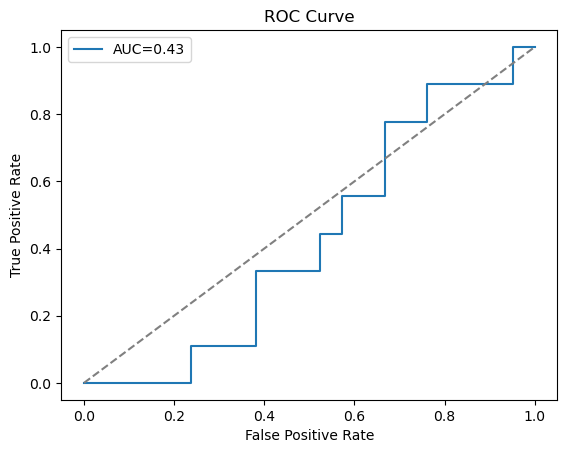

In [33]:
# ----------------------------
# Step 5: Evaluation
# ----------------------------
auc = roc_auc_score(y_test, y_pred_prob)          # Step 1: Compute AUC Range: 0.5 → 1.0
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)      # Step 2: Get ROC curve values ->
                                                  #plot True Positive Rate vs False Positive
ks = max(tpr - fpr)                               # Step 3: KS statistic : maximum vertical distance between the TPR curve and FPR curve

print(f"AUC: {auc:.4f}")
print(f"KS: {ks:.4f}")

plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [34]:
# ----------------------------
# Step 6: Scorecard Creation
# ----------------------------

# List of predictor variable names
x_columns = [col for col in X_train.columns if col != target]

# Create scorecard
card = sc.scorecard(bins, model, xcolumns=x_columns,
                    points0=600, odds0=35/65, pdo=50)

# Convert scorecard dict into DataFrame
card_df = pd.concat({k: pd.DataFrame(v) for k, v in card.items()})

# This step assigns a credit score to each customer in the test dataset
test_score = sc.scorecard_ply(test, card)

# Save scorecard & scores
output_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Final_Model_Scorecard.xlsx"
with pd.ExcelWriter(output_path) as writer:
    card_df.to_excel(writer, sheet_name="Scorecard")
    test_score.to_excel(writer, sheet_name="Test_Scores", index=False)

print(f" Scorecard and test scores saved successfully at {output_path}")


 Scorecard and test scores saved successfully at C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Final_Model_Scorecard.xlsx


In [35]:
# Clean the scorecard DataFrame
card_df = pd.concat({k: pd.DataFrame(v) for k, v in card.items()})
card_df = card_df.reset_index(level=0).rename(columns={'level_0': 'Variable'})

# Keep only useful columns
card_df = card_df[['Variable', 'bin', 'points']]

# Save cleaned version to Excel
output_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Final_Model_Scorecard_Clean.xlsx"
with pd.ExcelWriter(output_path) as writer:
    card_df.to_excel(writer, sheet_name="Scorecard", index=False)
    test_score.to_excel(writer, sheet_name="Test_Scores", index=False)

print(f"✅ Clean scorecard saved at {output_path}")


✅ Clean scorecard saved at C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Final_Model_Scorecard_Clean.xlsx


In [3]:
# Take your cleaned scorecard (Final_Model_Scorecard_Clean.xlsx).
# Take your model dataset (Final_Model_Dataset.xlsx).
# Apply the scorecard bins to each customer.
# Add basepoints (604) + sum of their variable bin points.
# Output the final score for all 100 customers in a new Excel file. 

In [36]:
import pandas as pd
import scorecardpy as sc

# ---------------------------
# Step 1: Load Data
# ---------------------------
data_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Final_Model_Dataset.xlsx"
scorecard_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Final_Model_Scorecard_Clean.xlsx"
output_path = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Customer_Final_Scores.xlsx"

df = pd.read_excel(data_path)
card = pd.read_excel(scorecard_path)

# ---------------------------
# Step 2: Apply Scorecard
# ---------------------------
# Convert scorecard file into scorecardpy format
# Make sure 'card' has the columns: Variable, bin, points
card_dict = {}
for var in card['Variable'].unique():
    temp = card[card['Variable'] == var][['bin', 'points']].set_index('bin').to_dict()['points']
    card_dict[var] = temp

# Apply scorecard to each row
def calculate_score(row):
    total = card[card['Variable'] == 'basepoints']['points'].iloc[0]  # basepoints
    for var in card['Variable'].unique():
        if var == 'basepoints': 
            continue
        value = row.get(var, None)
        if pd.isna(value):
            continue
        # Find matching bin
        for bin_label, pts in card_dict[var].items():
            if "[" in str(bin_label):  # range bin
                lo = float(bin_label.split(",")[0].replace("[","").replace("(","-inf"))
                hi = float(bin_label.split(",")[1].replace(")","").replace("]","inf"))
                if lo == float('-inf') or value >= lo:
                    if hi == float('inf') or value < hi:
                        total += pts
                        break
            else:  # categorical or cluster
                if str(value) == str(bin_label):
                    total += pts
                    break
    return total

df['Final_Score'] = df.apply(calculate_score, axis=1)

# ---------------------------
# Step 3: Save Output
# ---------------------------
df.to_excel(output_path, index=False)
print(f"✅ Final scores saved to {output_path}")


✅ Final scores saved to C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Customer_Final_Scores.xlsx


In [37]:
import os

# Folder to save individual files
output_folder = r"C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Customer_Files"
os.makedirs(output_folder, exist_ok=True)

# Limit number of customers (example: first 5)
n_customers = 3

# Loop through first n customers
for idx, row in df.head(n_customers).iterrows():
    customer_id = row.get("CustomerID", f"Cust_{idx+1}")  # adjust column name if you have unique ID
    output_file = os.path.join(output_folder, f"{customer_id}.xlsx")
    
    # Convert single row to DataFrame
    row_df = row.to_frame().T
    
    # Save to Excel
    row_df.to_excel(output_file, index=False)

print(f"✅ Saved {n_customers} customer files into {output_folder}")


✅ Saved 3 customer files into C:\Users\rajat\OneDrive\Desktop\Inputs scorecard\Customer_Files
